# Parallel Processing Demo 3: WorkflowSet Multi-Model Comparison

This notebook demonstrates parallel execution for multi-model comparison:
- `WorkflowSet.from_cross()` - Create all preprocessing × model combinations
- `WorkflowSet.fit_resamples()` - Parallel evaluation across CV folds
- Progress tracking with `verbose=True`
- Results ranking and visualization
- Performance comparisons (sequential vs parallel)

**Key Features Demonstrated:**
- ✅ `n_jobs` parameter for WorkflowSet evaluation
- ✅ CPU warning system for multi-workflow tasks
- ✅ Automatic workflow ranking
- ✅ Speedup measurements for large workflow sets
- ✅ Best model selection and finalization

## Setup and Data Loading

In [1]:
# Change to parent directory and install
import os
os.chdir('..')
!pip install -e .

Obtaining file:///Users/matthewdeane/Documents/Data%20Science/python/_projects/py-tidymodels
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for py-tidymodels (pyproject.toml) ... done
  Created wheel for py-tidymodels: filename=py_tidymodels-0.1.0-0.editable-py3-none-any.whl size=3190 sha256=032bc53cc26cce4c9e4931fae945cf17b96380a2e906c06ca84d11bb2bcae946
  Stored in directory: /private/var/folders/_6/yhy5krgn18d9n4fzp832dpr00000gn/T/pip-ephem-wheel-cache-ztcigjc5/wheels/0e/86/98/53b77320c2685404c16135684085fa8f94d4400fbcaf3922c1
Successfully built py-tidymodels
  Attempting uninstall: py-tidymodels
    Found existing installation: py-tidymodels 0.1.0
    Uninstalling py-tidymodels-0.1.0:
      Successfully uninstalled py-tidymodels-0.1.0


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import warnings

# py-tidymodels imports
from py_workflows import workflow
from py_parsnip import linear_reg, rand_forest
from py_recipes import recipe, all_numeric_predictors
from py_rsample import vfold_cv, initial_split, training, testing
from py_yardstick import metric_set, rmse, mae, r_squared
from py_workflowsets import WorkflowSet
from py_tune.parallel_utils import get_cpu_count

# Seaborn styling
sns.set_style('whitegrid')

print("All imports successful!")

All imports successful!


In [3]:
# Load data
raw_data = pd.read_csv('_md/__data/preem.csv')
df = raw_data.copy()
df['date'] = pd.to_datetime(df['date'])

print(f"Data shape: {df.shape}")
print(f"Date range: {df['date'].min()} to {df['date'].max()}")
display(df.head())

Data shape: (57, 10)
Date range: 2020-04-01 00:00:00 to 2024-12-01 00:00:00


,date,mean_med_diesel_crack_input1_trade_month_lag2,mean_nwe_hsfo_crack_trade_month_lag1,mean_nwe_lsfo_crack_trade_month,mean_nwe_ulsfo_crack_trade_month_lag3,mean_sing_gasoline_vs_vlsfo_trade_month,mean_sing_vlsfo_crack_trade_month_lag3,new_sweet_sr_margin,target,totaltar
0,2020-04-01,-56.18,-11.43,-3.07,28.58,-16.09,26.91,0.47,137.65,0.0
1,2020-05-01,-42.36,-9.17,3.89,22.64,-8.75,20.36,0.57,113.53,0.0
2,2020-06-01,-30.21,-8.58,-3.44,13.43,-4.28,11.32,6.61,43.31,0.0
3,2020-07-01,-28.86,-6.86,-2.71,10.74,-3.20,8.53,-1.55,79.77,0.0
4,2020-08-01,-38.80,-5.86,-2.63,4.58,-5.35,6.26,-2.70,48.27,0.0


In [4]:
# Create train/test split
split = initial_split(df, prop=0.75, seed=123)
train_data = training(split)
test_data = testing(split)

print(f"Training set: {train_data.shape[0]} rows")
print(f"Test set: {test_data.shape[0]} rows")

Training set: 42 rows
Test set: 15 rows


In [5]:
# Define base formula and metrics
FORMULA = "target ~ ."
metrics = metric_set(rmse, mae, r_squared)

print(f"Formula: {FORMULA}")
print(f"Metrics: rmse, mae, r_squared")

Formula: target ~ .
Metrics: rmse, mae, r_squared


## System Information

In [6]:
# Check system resources
cpu_count = get_cpu_count()
print(f"✓ Detected {cpu_count} CPU cores")
print(f"✓ Joblib backend: loky (multiprocessing)")
print(f"\nThis system can efficiently run up to {cpu_count} parallel jobs.")

✓ Detected 8 CPU cores
✓ Joblib backend: loky (multiprocessing)

This system can efficiently run up to 8 parallel jobs.


## Part 1: Create WorkflowSet

We'll create multiple preprocessing strategies and models, then combine them into a WorkflowSet.

In [7]:
# Define preprocessing strategies
formulas = [
    "target ~ .",  # All features
]

recipes = [
    recipe().step_normalize(all_numeric_predictors()),
    recipe().step_normalize(all_numeric_predictors()).step_pca(all_numeric_predictors(), num_comp=3),
    recipe().step_poly(all_numeric_predictors(), degree=2)
]

# Combine formulas and recipes
preproc = formulas + recipes

print(f"Preprocessing strategies: {len(preproc)}")
print("  1. Formula (minimal): target ~ .")
print("  2. Recipe (normalized): Normalize all numeric")
print("  3. Recipe (PCA): Normalize + PCA (3 components)")
print("  4. Recipe (polynomial): Polynomial features (degree 2)")

Preprocessing strategies: 4
  1. Formula (minimal): target ~ .
  2. Recipe (normalized): Normalize all numeric
  3. Recipe (PCA): Normalize + PCA (3 components)
  4. Recipe (polynomial): Polynomial features (degree 2)


In [8]:
# Define models
models = [
    linear_reg(),
    linear_reg(penalty=0.1, mixture=1.0).set_engine("sklearn"),  # Lasso
    rand_forest(trees=100, min_n=5).set_mode('regression')
]

print(f"Models: {len(models)}")
print("  1. Linear Regression (OLS)")
print("  2. Linear Regression (Lasso, penalty=0.1)")
print("  3. Random Forest (100 trees, min_n=5)")

Models: 3
  1. Linear Regression (OLS)
  2. Linear Regression (Lasso, penalty=0.1)
  3. Random Forest (100 trees, min_n=5)


In [9]:
# Create WorkflowSet from all combinations
wf_set = WorkflowSet.from_cross(preproc=preproc, models=models)

n_workflows = len(wf_set.workflows)
print(f"\n✓ Created WorkflowSet with {n_workflows} workflows")
print(f"  ({len(preproc)} preprocessing strategies × {len(models)} models)")

# Show workflow IDs
print("\nWorkflow IDs:")
for wf_id in wf_set.workflows.keys():
    print(f"  - {wf_id}")


✓ Created WorkflowSet with 12 workflows
  (4 preprocessing strategies × 3 models)

Workflow IDs:
  - prep_1_linear_reg_1
  - prep_1_linear_reg_2
  - prep_1_rand_forest_3
  - prep_2_linear_reg_1
  - prep_2_linear_reg_2
  - prep_2_rand_forest_3
  - prep_3_linear_reg_1
  - prep_3_linear_reg_2
  - prep_3_rand_forest_3
  - prep_4_linear_reg_1
  - prep_4_linear_reg_2
  - prep_4_rand_forest_3


## Part 2: Sequential vs Parallel Evaluation

In [10]:
# Create CV folds
folds = vfold_cv(train_data, v=5, seed=123)
n_folds = len(folds)
total_fits = n_workflows * n_folds

print(f"CV Configuration:")
print(f"  Workflows: {n_workflows}")
print(f"  CV folds: {n_folds}")
print(f"  Total fits: {total_fits} ({n_workflows} × {n_folds})")
print(f"\nThis is a good candidate for parallel execution!")

CV Configuration:
  Workflows: 12
  CV folds: 5
  Total fits: 60 (12 × 5)

This is a good candidate for parallel execution!


### Sequential Execution (Baseline)

In [11]:
# Sequential evaluation
print(f"Running SEQUENTIAL WorkflowSet evaluation ({total_fits} fits)...")
start = time.time()
results_seq = wf_set.fit_resamples(
    resamples=folds,
    metrics=metrics,
    n_jobs=1,  # Sequential
    verbose=True
)
seq_time = time.time() - start

print(f"\n✓ Sequential execution completed in {seq_time:.2f} seconds")
print(f"  ({seq_time / total_fits:.2f} seconds per fit)")

Running SEQUENTIAL WorkflowSet evaluation (60 fits)...
Processing 12 workflows (sequential)...
  [1/12] Fitting prep_1_linear_reg_1...
  [2/12] Fitting prep_1_linear_reg_2...
  [3/12] Fitting prep_1_rand_forest_3...
  [4/12] Fitting prep_2_linear_reg_1...
  [5/12] Fitting prep_2_linear_reg_2...
  [6/12] Fitting prep_2_rand_forest_3...
  [7/12] Fitting prep_3_linear_reg_1...
  [8/12] Fitting prep_3_linear_reg_2...
  [9/12] Fitting prep_3_rand_forest_3...
  [10/12] Fitting prep_4_linear_reg_1...
  [11/12] Fitting prep_4_linear_reg_2...
  [12/12] Fitting prep_4_rand_forest_3...
✓ Workflow evaluation complete: 12 successful

✓ Sequential execution completed in 1.70 seconds
  (0.03 seconds per fit)


In [12]:
# View sequential results
metrics_seq = results_seq.collect_metrics()
print("\nTop 5 workflows (sequential, by RMSE):")
display(results_seq.rank_results('rmse', n=5))


Top 5 workflows (sequential, by RMSE):


,rank,wflow_id,preprocessor,model,mae_mean,r_squared_mean,rmse_mean,mae_n,r_squared_n,rmse_n,mae_std,r_squared_std,rmse_std
7,1,prep_3_linear_reg_2,recipe,linear_reg,30.390451,-0.735310,36.907364,5.0,5.0,5.0,7.807237,0.716573,6.657616
6,2,prep_3_linear_reg_1,recipe,linear_reg,30.424770,-0.739724,36.952006,5.0,5.0,5.0,7.847130,0.719899,6.758724
5,3,prep_2_rand_forest_3,recipe,rand_forest,29.513273,-0.646240,36.984267,5.0,5.0,5.0,7.266871,0.690625,9.682602
2,4,prep_1_rand_forest_3,formula,rand_forest,29.516828,-0.646427,36.987405,5.0,5.0,5.0,7.263712,0.690428,9.682105
11,5,prep_4_rand_forest_3,recipe,rand_forest,29.950824,-0.768259,37.898697,5.0,5.0,5.0,3.753589,0.540373,5.504535


### Parallel Execution with All Cores

In [13]:
# Parallel evaluation
print(f"Running PARALLEL WorkflowSet evaluation ({total_fits} fits, n_jobs=-1)...")
start = time.time()
results_par = wf_set.fit_resamples(
    resamples=folds,
    metrics=metrics,
    n_jobs=-1,  # Use all cores
    verbose=True
)
par_time = time.time() - start

speedup = seq_time / par_time
efficiency = (speedup / cpu_count) * 100

print(f"\n✓ Parallel execution completed in {par_time:.2f} seconds")
print(f"  ({par_time / total_fits:.2f} seconds per fit)")
print(f"✓ Speedup: {speedup:.2f}x")
print(f"✓ Efficiency: {efficiency:.1f}%")

Running PARALLEL WorkflowSet evaluation (60 fits, n_jobs=-1)...
Processing 12 workflows using 8 cores (loky backend)...


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   1 tasks      | elapsed:    3.0s
[Parallel(n_jobs=8)]: Done   3 out of  12 | elapsed:    3.2s remaining:    9.5s
[Parallel(n_jobs=8)]: Done   5 out of  12 | elapsed:    3.2s remaining:    4.5s
[Parallel(n_jobs=8)]: Done   7 out of  12 | elapsed:    3.5s remaining:    2.5s
[Parallel(n_jobs=8)]: Done   9 out of  12 | elapsed:    3.7s remaining:    1.2s


✓ Workflow evaluation complete: 12 successful

✓ Parallel execution completed in 4.02 seconds
  (0.07 seconds per fit)
✓ Speedup: 0.42x
✓ Efficiency: 5.3%


[Parallel(n_jobs=8)]: Done  12 out of  12 | elapsed:    4.0s finished


### Results Consistency Check

In [14]:
# Verify results are identical
metrics_par = results_par.collect_metrics()

print("Consistency Check (top workflow):")
top_wf_id = results_seq.rank_results('rmse', n=1).iloc[0]['wflow_id']

seq_metrics = metrics_seq[metrics_seq['wflow_id'] == top_wf_id]
par_metrics = metrics_par[metrics_par['wflow_id'] == top_wf_id]

for metric in ['rmse', 'mae', 'r_squared']:
    seq_val = seq_metrics[seq_metrics['metric'] == metric]['mean'].values[0]
    par_val = par_metrics[par_metrics['metric'] == metric]['mean'].values[0]
    
    match = np.isclose(seq_val, par_val, rtol=1e-10)
    status = "✓ IDENTICAL" if match else "✗ DIFFERENT"
    print(f"  {metric}: {status} ({seq_val:.6f})")

print("\n✓ All parallel executions produce identical results to sequential!")

Consistency Check (top workflow):
  rmse: ✓ IDENTICAL (36.907364)
  mae: ✓ IDENTICAL (30.390451)
  r_squared: ✓ IDENTICAL (-0.735310)

✓ All parallel executions produce identical results to sequential!


### Performance Comparison

,Configuration,n_jobs,Time (s),Time per fit (s),Speedup,Efficiency (%)
0,Sequential,1,1.700878,0.028348,1.000000,100.000000
1,Parallel (8 cores),-1,4.023643,0.067061,0.422721,5.284011


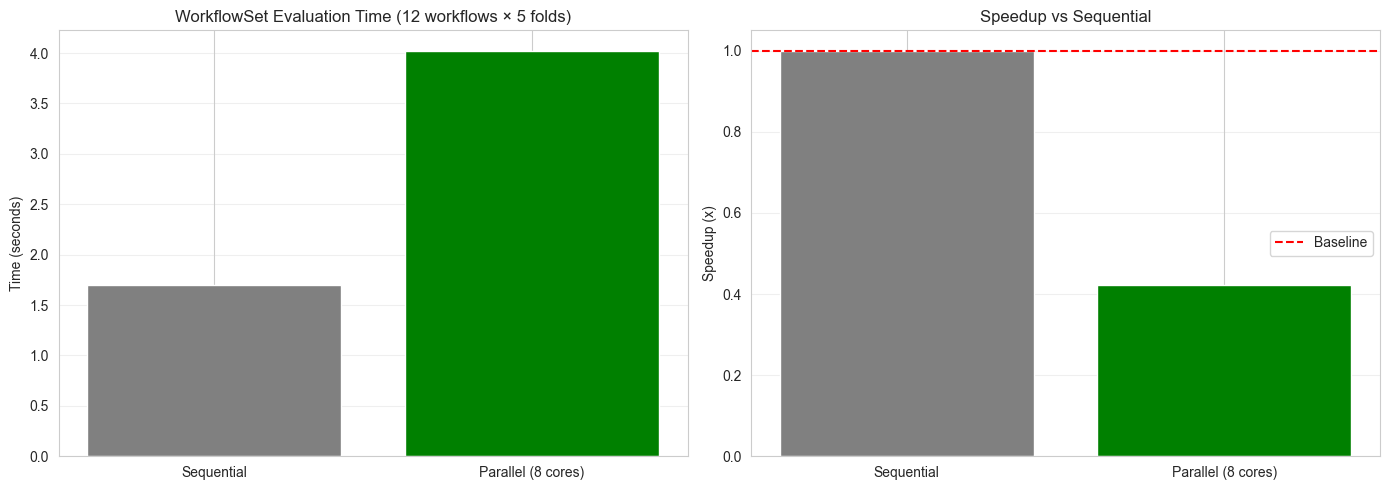

In [15]:
# Create performance comparison
perf_df = pd.DataFrame({
    'Configuration': ['Sequential', f'Parallel ({cpu_count} cores)'],
    'n_jobs': [1, -1],
    'Time (s)': [seq_time, par_time],
    'Time per fit (s)': [seq_time / total_fits, par_time / total_fits],
    'Speedup': [1.0, speedup],
    'Efficiency (%)': [100.0, efficiency]
})

display(perf_df)

# Plot performance
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Total time comparison
ax1.bar(perf_df['Configuration'], perf_df['Time (s)'], color=['gray', 'green'])
ax1.set_ylabel('Time (seconds)')
ax1.set_title(f'WorkflowSet Evaluation Time ({n_workflows} workflows × {n_folds} folds)')
ax1.grid(axis='y', alpha=0.3)

# Speedup
ax2.bar(perf_df['Configuration'], perf_df['Speedup'], color=['gray', 'green'])
ax2.set_ylabel('Speedup (x)')
ax2.set_title('Speedup vs Sequential')
ax2.axhline(y=1, color='r', linestyle='--', label='Baseline')
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## Part 3: Results Analysis and Ranking

In [16]:
# Rank all workflows
ranked = results_par.rank_results('rmse', n=n_workflows)

print(f"All {n_workflows} workflows ranked by RMSE:")
display(ranked[['wflow_id', 'rmse', 'mae', 'r_squared', 'rank']])

All 12 workflows ranked by RMSE:


KeyError: "['rmse', 'mae', 'r_squared'] not in index"

AttributeError: 'Figure' object has no attribute 'update_layout'

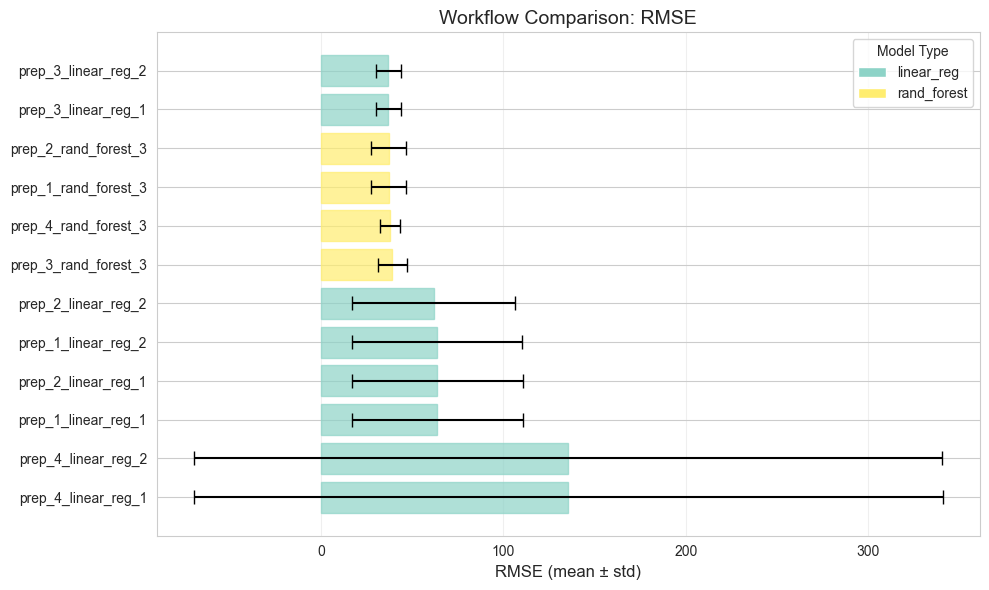

In [17]:
# Visualize workflow comparison
fig = results_par.autoplot('rmse')
fig.update_layout(
    title=f'WorkflowSet Performance Comparison ({n_workflows} workflows)',
    height=500
)
fig.show()

In [ ]:
# Compare metrics across workflows
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

metrics_to_plot = ['rmse', 'mae', 'r_squared']
colors = ['steelblue', 'coral', 'mediumseagreen']

for i, (metric, color) in enumerate(zip(metrics_to_plot, colors)):
    metric_data = metrics_par[metrics_par['metric'] == metric].sort_values('mean')
    
    axes[i].barh(range(len(metric_data)), metric_data['mean'], color=color, alpha=0.7)
    axes[i].set_yticks(range(len(metric_data)))
    axes[i].set_yticklabels(metric_data['wflow_id'], fontsize=8)
    axes[i].set_xlabel(metric.upper())
    axes[i].set_title(f'{metric.upper()} by Workflow')
    axes[i].grid(axis='x', alpha=0.3)
    
    # Highlight best
    if metric == 'r_squared':
        best_idx = metric_data['mean'].idxmax()
    else:
        best_idx = metric_data['mean'].idxmin()
    
    best_pos = list(metric_data.index).index(best_idx)
    axes[i].barh(best_pos, metric_data.loc[best_idx, 'mean'], color='gold', alpha=0.9)

plt.tight_layout()
plt.show()

## Part 4: Best Workflow Selection

In [ ]:
# Extract best workflow
best_wf_id = ranked.iloc[0]['wflow_id']
best_workflow = wf_set[best_wf_id]

print(f"Best workflow: {best_wf_id}")
print(f"\nPerformance metrics:")
best_metrics = ranked.iloc[0]
print(f"  RMSE: {best_metrics['rmse']:.4f} (±{best_metrics.get('rmse_std', 0):.4f})")
print(f"  MAE:  {best_metrics['mae']:.4f} (±{best_metrics.get('mae_std', 0):.4f})")
print(f"  R²:   {best_metrics['r_squared']:.4f} (±{best_metrics.get('r_squared_std', 0):.4f})")

In [ ]:
# Fit best workflow on full training set
print(f"\nFitting best workflow ({best_wf_id}) on full training data...")
best_fit = best_workflow.fit(train_data)
print("✓ Fit complete")

# Evaluate on test set
best_fit = best_fit.evaluate(test_data)

# Calculate metrics
predictions = best_fit.predict(test_data)
test_metrics_df = pd.DataFrame()
for metric_fn in [rmse, mae, r_squared]:
    metric_result = metric_fn(test_data['target'], predictions['.pred'])
    test_metrics_df = pd.concat([test_metrics_df, metric_result], ignore_index=True)

print("\nTest set performance:")
display(test_metrics_df)

## Part 5: CPU Warning Demonstration

In [ ]:
# Create smaller WorkflowSet to trigger warning
small_wf_set = WorkflowSet.from_cross(
    preproc=["target ~ ."],
    models=[linear_reg()]
)

print(f"Small WorkflowSet has {len(small_wf_set.workflows)} workflow.")
print(f"Requesting {cpu_count * 2} workers...\n")

with warnings.catch_warnings(record=True) as w:
    warnings.simplefilter("always")
    
    results_warn = small_wf_set.fit_resamples(
        resamples=folds,
        metrics=metrics,
        n_jobs=cpu_count * 2,  # More workers than tasks
        verbose=False
    )
    
    if w:
        print("⚠️  WARNING TRIGGERED:")
        print(f"    {w[0].message}")
        print(f"\n💡 Recommendation: For 1 workflow × 5 folds, use n_jobs=5 or fewer")

## Summary and Recommendations

In [ ]:
print("=" * 80)
print("PARALLEL WORKFLOWSET PERFORMANCE SUMMARY")
print("=" * 80)
print(f"\nSystem: {cpu_count} CPU cores")
print(f"WorkflowSet: {n_workflows} workflows ({len(preproc)} prep × {len(models)} models)")
print(f"CV: {n_folds} folds")
print(f"Total fits: {total_fits}")

print(f"\nPerformance:")
print(f"  Sequential: {seq_time:.2f}s ({seq_time/total_fits:.3f}s per fit)")
print(f"  Parallel ({cpu_count} cores): {par_time:.2f}s ({par_time/total_fits:.3f}s per fit)")
print(f"  Speedup: {speedup:.2f}x")
print(f"  Efficiency: {efficiency:.1f}%")

print(f"\nBest workflow: {best_wf_id}")
print(f"  CV RMSE: {best_metrics['rmse']:.4f}")
test_rmse = test_metrics_df[test_metrics_df['metric'] == 'rmse']['value'].values[0]
print(f"  Test RMSE: {test_rmse:.4f}")

print("\n" + "=" * 80)
print("RECOMMENDATIONS")
print("=" * 80)
print(f"\n✅ Use parallel WorkflowSet (n_jobs=-1) when:")
print(f"   - Comparing many workflows (>{cpu_count})")
print(f"   - Each workflow takes >1 second per fold")
print(f"   - Total fits > 20-30 (workflows × folds)")
print(f"   - Using complex preprocessing (recipes with PCA, polynomial features)")
print(f"   - Using complex models (random forest, boosting)")

print(f"\n⚠️  Use sequential (n_jobs=1) when:")
print(f"   - Few workflows (< {cpu_count})")
print(f"   - Simple/fast workflows")
print(f"   - Total execution time < 30 seconds")
print(f"   - Debugging workflow issues")

print(f"\n💡 Tips:")
print(f"   - Always use verbose=True to monitor progress")
print(f"   - Watch for CPU warnings - they help optimize performance")
print(f"   - Use rank_results() to identify best workflows")
print(f"   - Use autoplot() for quick visual comparison")
print(f"   - Parallel speedup scales with number of workflows and fold complexity")
print("=" * 80)